In [10]:
 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import datetime


# Feeding the models

* DGVMs require a parametrisation of the land surface
* ... at a coarse scale (10s-100s km)
* ... over large periods of time (decades!)
* But do we prescribe these parameters?
* Can we assess DGVM assumptions?
* Does EO help?


# How can EO help?

* Modelling of **energy fluxes**
    * Radiation budget
    * Photosynthesis
* We can interpret EO data in terms of 
    * Same parameters
    * Same physical models
* We can either 
    * Compare models with "reality"
    * Prescribe parameters for the model
* But remember that EO data was **limited**?

# Albedo (Bi-hemispherical reflectance)

* Albedo: fraction of incoming radiation that is **reflected**
* Consider **broad spectral bands**
* In MULTIPLY, aim to **infer** albedo from combining different sensors
    * Coarse spatial resolution
        * MODIS
        * S3/OLCI
        * S3/SLSTR
        * VIIRS
* Two measurements per time step per pixel: **VIS**ible and **N**ear**I**nfra**R**ed

![](bhr_MMR.png)

# Interpreting albedo

* Use a simple model
    * ... which one can use inside a DGVM (Seller's, JRC-TIP, etc)
* Describe albedo as a function of
    * optical properties of soil
    * optical properties of leaves
    * Amount and structure of canopy
* Only that we simplify the structure $\longrightarrow$ **effective LAI**
* So, we have two (noisy!)observations...
    * ... and 7 parameters!
* How do we go about that?!!

# The model

* **JRC-TIP**
* 7 parameters $\longrightarrow$ predicts $\alpha_{VIS}$ & $\alpha_{NIR}$
* Simplify 3D structure to have simple physics
* We don't actually use the model
    * $\longrightarrow$ We use **emulators**
* The model is present in some DGVMs already
* ... or we could use another BHR model!

# Priors

* Need to limit the solution space!
* What are our parameters?
    * leaf reflectance and transmittance (VIS+NIR)
    * soil albedo (VIS+NIR)
    * effective LAI

# Leaves
![](tip_priors.png)

# Setting up the problem

* First, we need some observations
    * Currently, using MODIS MCD43 Albedo product
    * Will use MULTIPLY coarse resolution product when available
* We also need  a **state mask**
* And finally, our RT model is stored as an **emulator** in a file
    * If you want to change the RT model, you change the emulator file!

In [2]:
import numpy as np
from kafka.input_output import BHRObservations, KafkaOutput

parameter_list = ["w_vis", "x_vis", "a_vis",
                     "w_nir", "x_nir", "a_nir", "TeLAI"]
    
tile = "h17v05"
start_time = "2017001"    
emulator = "./SAIL_emulator_both_500trainingsamples.pkl"
mcd43a1_dir="/data/selene/ucfajlg/Ujia/MCD43/"
    
mask = np.zeros((2400,2400),dtype=np.bool8)
mask[650:730, 1180:1280] = True # Arros

bhr_data =  BHRObservations(emulator, tile, mcd43a1_dir, start_time,
                                end_time=None, mcd43a2_dir=None)

IOError: mcd43a1_dir does not exist!

In [3]:
from kafka.inference import block_diag

class JRCPrior(object):
    """Dummpy 2.7/3.6 prior class following the same interface as 3.6 only
    version."""

    def __init__ (self, parameter_list, state_mask):
        """It makes sense to have the list of parameters and state mask
        defined at this point, as they won't change during processing."""
        self.mean, self.covar, self.inv_covar = self._tip_prior() 
        self.parameter_list = parameter_list
        if isinstance(state_mask, (np.ndarray, np.generic) ):
            self.state_mask = state_mask
        else:
            self.state_mask = self._read_mask(state_mask)
            
    def _read_mask(self, fname):
        """Tries to read the mask as a GDAL dataset"""
        if not os.path.exists(fname):
            raise IOError("State mask is neither an array or a file that exists!")
        g = gdal.Open(fname)
        if g is None:
            raise IOError("{:s} can't be opened with GDAL!".format(fname))
        mask = g.ReadAsArray()
        return mask

    def _tip_prior(self):
        """The JRC-TIP prior in a convenient function which is fun for the whole
        family. Note that the effective LAI is here defined in transformed space
        where TLAI = exp(-0.5*LAIe).

        Returns
        -------
        The mean prior vector, covariance and inverse covariance matrices."""
        # broadly TLAI 0->7 for 1sigma
        sigma = np.array([0.12, 0.7, 0.0959, 0.15, 1.5, 0.2, 0.5])
        x0 = np.array([0.17, 1.0, 0.1, 0.7, 2.0, 0.18, np.exp(-0.5*2.)])
        # The individual covariance matrix
        little_p = np.diag(sigma**2).astype(np.float32)
        little_p[5, 2] = 0.8862*0.0959*0.2
        little_p[2, 5] = 0.8862*0.0959*0.2

        inv_p = np.linalg.inv(little_p)
        return x0, little_p, inv_p

    def process_prior ( self, time, inv_cov=True):
        # Presumably, self._inference_prior has some method to retrieve 
        # a bunch of files for a given date...
        n_pixels = self.state_mask.sum()
        x0 = np.array([self.mean for i in xrange(n_pixels)]).flatten()
        if inv_cov:
            inv_covar_list = [self.inv_covar for m in xrange(n_pixels)]
            inv_covar = block_diag(inv_covar_list, dtype=np.float32)
            return x0, inv_covar
        else:
            covar_list = [self.covar for m in xrange(n_pixels)]
            covar = block_diag(covar_list, dtype=np.float32)
            return x0, covar


# The prior...

* We use a prior object, `JRCPrior`. 
* This prior encodes the JRC TIP prior 
* Prior is subjective: if you don't agree with it, you can set **your own**!

In [4]:
the_prior = JRCPrior(parameter_list, mask)


So we have a prior, observations, a model (associated to the observations)...

What else do we need? 
    * We need a starting point

Currently MULTIPLY inference engine works as a **filter**
    * It inverts observations **sequentially**
    * We need to give it starting prior
    * ... Which we can query the prior engine for
    * The prior is defined as a
        * Mean vector $\vec{\mu}$, `x_forecast`
        * Prior **inverse** covariance matrix $\mathbf{C}_{prior}^{-1}$, `P_forecast_inv`

Number of inference pixels: 8000
Size of the state vector: 56000
Size of the inverse covariance matrix: 56000 * 56000


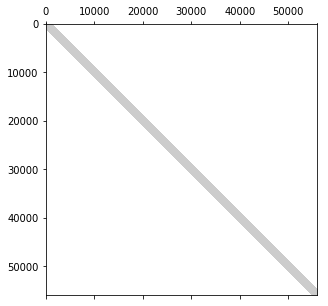

In [18]:
# Query the JRC-TIP prior for a mean and inverse covariance matrix
x_forecast, P_forecast_inv = the_prior.process_prior(None)
print("Number of inference pixels: {:d}".format(mask.sum()))
print("Size of the state vector: {:d}".format(x_forecast.shape[0]))
print("Size of the inverse covariance matrix: {:d} * {:d}".format(
    P_forecast_inv.shape[0], P_forecast_inv.shape[1]))
plt.figure(figsize=(10,5))
plt.spy(P_forecast_inv, c="0.8", ms=5)


We have set everything set up, except for **when** we want the system to report an **inference**

* Observations are every 16 days
* Assume we want to invert every observation
* If we wanted (eg) daily estimates, the system could **interpolate** using a **dynamic temporal model**
* ... but not using it this time

So let's define the inference grid: a set of times when we will produced inferences

In [7]:
base = datetime.datetime(2017,7,1)
num_days = 60
time_grid = list((base + datetime.timedelta(days=x) 
                  for x in range(0, num_days, 16)))
print(time_grid)

[datetime.datetime(2017, 7, 1, 0, 0), datetime.datetime(2017, 7, 17, 0, 0), datetime.datetime(2017, 8, 2, 0, 0), datetime.datetime(2017, 8, 18, 0, 0)]


Nearly there!

This would be quite useless if we didn't set up somewhere to save the data. 

In this case, we use GeoTIFF files for different parameters

In [ ]:
projection, geotransform = bhr_data.define_output()
output = KafkaOutput(parameter_list, geotransform, projection, "./")

In [8]:
# Putting it all together
from kafka import LinearKalman
from kafka.inference import create_nonlinear_observation_operator

kf = LinearKalman(bhr_data, output, mask, 
                      create_nonlinear_observation_operator, parameter_list,
                      state_propagation=None,
                      prior=the_prior,
                      linear=False)


kf.run(time_grid, x_forecast, None, P_forecast_inv, iter_obs_op=True)


NameError: name 'bhr_data' is not defined